# Simple network where a centrality crossing occurs

In [1]:
import numpy as np
import xgi
import networkx as nx
import copy
from collections import OrderedDict
from scipy.stats import kendalltau, spearmanr
import matplotlib.pyplot as plt

from hyperfunctions import *

In [2]:
def G_to_dict(G):
    '''
    Prepare the Networkx Graph for the Hypernetx package
    '''
    
    Gdict = {}
    
    for i, edge in enumerate(G.edges):
        Gdict['edge' + str(i)] = list(edge)
    
    return Gdict

In [3]:
def compare_cents(G, rank_compare=None):
    '''
    Given a networkx graph G compute its xgi 3-Hypergraph H,
    and compare the normalized EIG centrality of G
    with the normalized HEC centrality of H.
    If rank_compare is spearmanr or kendalltau, return that correlation value.
    '''

    # Compute the EIG
    EIG = list(nx.eigenvector_centrality_numpy(G).values())
    
    print(EIG)
    
    # Create the hypergraph
    edgedict = G_to_dict(G)
    H = xgi.Hypergraph(edgedict)
    H3 = uniformize(H, m=3)
    
    # Compute the HEC, remove the * score, sort and list
    HEC = xgi.HEC_centrality(H3)
    HEC.pop('*')
    HEC = list(OrderedDict(sorted(HEC.items())).values())

    # Normalize and concatenate
    EIG /= np.sum(EIG)
    HEC /= np.sum(HEC)
    cents = np.stack((EIG, HEC)).T

    if rank_compare:
        return cents, rank_compare(EIG, HEC).statistic
    else:
        return cents


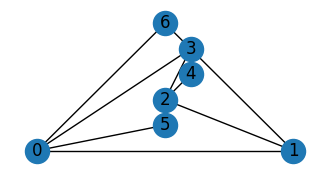

In [4]:
G = nx.Graph()
nx.add_path(G,[0,1,2,3])
G.add_edges_from([(3,1), (2,4), (0,5), (5,2), (0,3), (3,6), (6,0)])
fig, ax = plt.subplots(1,1, figsize=(4,2))
nx.draw_planar(G, ax=ax, with_labels=True)

In [5]:
cents, rank = compare_cents(G, rank_compare=spearmanr)
print(cents, rank)

[0.46584795879949814, 0.4279029905945557, 0.41254600341063075, 0.4989503517755183, 0.12816669501209407, 0.2728928413420902, 0.2997362955824614]
[[0.18588984 0.1676735 ]
 [0.17074845 0.15566171]
 [0.16462047 0.16185542]
 [0.19909887 0.17211587]
 [0.05114305 0.08841934]
 [0.10889391 0.12616254]
 [0.1196054  0.12811162]] 0.9642857142857145


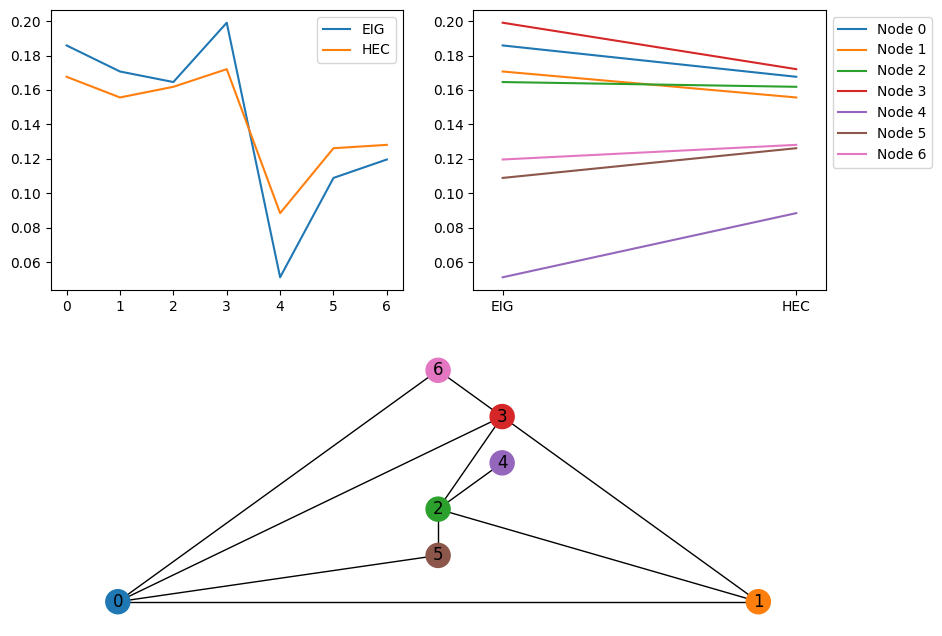

In [6]:
fig = plt.figure(figsize=(10,8))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

# First figure

ax1.plot(cents[:,0], label='EIG')
ax1.plot(cents[:,1], label='HEC')
ax1.legend()

# Second figure

ax2.set_xlim(-0.1,1.1)
ax2.set_xticks([0,1], ['EIG', 'HEC'])

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, row in enumerate(cents):
    ax2.plot(row, color=colors[i], label=f'Node {i}')

ax2.legend(bbox_to_anchor=(1,1))


# Graph:
ax3 = fig.add_subplot(212)
nx.draw_planar(G, ax=ax3, with_labels=True, node_color=colors[:len(cents[:,0])])

In [7]:
EIG = cents[:,0]
HEC = cents[:,1]

In [8]:
kendalltau(EIG, HEC)

SignificanceResult(statistic=0.9047619047619049, pvalue=0.002777777777777778)

In [9]:
spearmanr(EIG, HEC)

SignificanceResult(statistic=0.9642857142857145, pvalue=0.0004541491691941689)

In [10]:
EIG, HEC

(array([0.18588984, 0.17074845, 0.16462047, 0.19909887, 0.05114305,
        0.10889391, 0.1196054 ]),
 array([0.1676735 , 0.15566171, 0.16185542, 0.17211587, 0.08841934,
        0.12616254, 0.12811162]))

In [11]:
EIG = list(nx.eigenvector_centrality_numpy(G).values())
EIG /= np.sum(EIG)
EIG

array([0.18588984, 0.17074845, 0.16462047, 0.19909887, 0.05114305,
       0.10889391, 0.1196054 ])

In [12]:
edgedict = G_to_dict(G)
H = xgi.Hypergraph(edgedict)
H3 = uniformize(H, m=3)

# Compute the HEC, remove the * score, sort and list
HECdict = xgi.HEC_centrality(H3)
print(HECdict)
HECdict.pop('*')
HEC = list(OrderedDict(sorted(HECdict.items())).values())

HEC /= np.sum(HEC)
HEC


{0: 0.13693327961468854, 1: 0.12712365142041945, 5: 0.1030326734893679, 3: 0.1405612098842825, 6: 0.10462442955677265, 2: 0.13218184930860938, 4: 0.07220908177217207, '*': 0.18333382495368752}


array([0.1676735 , 0.15566171, 0.16185542, 0.17211587, 0.08841934,
       0.12616253, 0.12811162])

**Nodes 1 and 2 have their centralities crossed, for some reason**

In [13]:
c0 = EIG[0]; c4 = EIG[4]; c5 = EIG[5]
q0 = HEC[0]; q4 = HEC[4]; q5 = HEC[5]

In [14]:
assert c4 < c5 and c5 < c0
assert q4 < q5 and q5 < q0

In [15]:
assert c0 > c4 + c5
assert q0 < q4 + q5